# Cleaning US Census Data

The goal of this project is to make US Census data scalable and repeatable, converting data from multiple CSV files to pandas' DataFrames, as well as to collect some interesting insights from it and create informative visualisations as a result. 


## Data Investigation

The first visualization we are going to make is a scatterplot that shows the average income in a state vs the percentage of women in that state. To implement this task we first need to convert CSV files to DataFrames to make them flexible and applicable for various data analytical tasks, visualisation among them.

After importing all necessary tools for work, we'll loop through the census files available and load them into DataFrames, using glob. Then, concatenate all of those DataFrames together into one DataFrame and call it `us_census`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Upload csv file to DataFrame
states = glob.glob('state*.csv')
df_list = []
for i in states:
  data = pd.read_csv(i)
  df_list.append(data)   
us_census = pd.concat(df_list).reset_index(drop=True)

us_census.head(5)

,Unnamed: 0,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,0,New Jersey,8904413,18.74950049950049%,56.488761238761285%,14.387862137862117%,0.11533466533466513%,8.159990009990018%,0.031318681318681325%,$76581.08341708542,4343027M_4561386F
1,1,New Mexico,2084117,45.28293172690762%,40.69799196787147%,1.7550200803212852%,9.248594377510045%,1.23433734939759%,0.04277108433734938%,$47329.96787148595,1032414M_1051703F
2,2,New York,19673174,17.241424747786684%,56.4701050030883%,15.668046119003515%,0.32163887173152117%,7.8971587399629355%,0.023450689726168417%,$64290.74911292006,9541801M_10131373F
3,3,North Carolina,9845333,8.464762782128062%,64.5976508521419%,21.3951174573929%,1.0854905573468434%,2.317457392906495%,0.05232611699677568%,$49937.46413697362,4795408M_5049925F
4,4,North Dakota,721640,2.832682926829267%,87.44829268292683%,1.2843902439024397%,5.651219512195119%,0.9619512195121945%,NaN,$58188.112195121954,367963M_353677F


Let's start by looking at the data types of the `us_census` DataFrame in case they might hinder us as we try to make histograms.

In [2]:
us_census.dtypes

Unnamed: 0     int64
State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income        object
GenderPop     object
dtype: object

Seems like many numerical values have been written as an `object` data type instead of integers or floats. We can not work with such types, so let's convert them to more useful ones. Considering that we will probably need to perform this action repeatedly let's write a function that would remove unnecessary symbols and perform reformating simultaneously.

In [3]:
# Remove= unnecessary symbols & reformating
cut_the_tails = lambda column: pd.to_numeric(column.replace('[\$%MF]', '', regex=True))

Let's use our function to turn the "Income" column into a numerical type.

In [4]:
# Remove unnecessary symbols & reformat Income
us_census.Income = cut_the_tails(us_census.Income)
us_census.Income.dtypes

dtype('float64')

Now let's look at the "GenderPop" column. We are going to separate this into two columns to `Males` and `Females` as well as to remove unnecessary symbols and convert both to numerical datatypes to get the result we need.

In [5]:
# Remove unnecessary symbols
us_census.GenderPop = us_census.GenderPop.replace('M|F', '', regex=True)
# Split GenderPop in Males and Females
genders = us_census.GenderPop.str.split('_')
us_census['Males'] = genders.str.get(0)
us_census['Females'] = genders.str.get(1)
# Reformat resulting 2 colums
us_census.Males = pd.to_numeric(us_census.Males)
us_census.Females = pd.to_numeric(us_census.Females)
# Remove GenderPop from the table
us_census.drop(['GenderPop', 'Unnamed: 0'], axis=1, inplace=True)

us_census.head(5)

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,Males,Females
0,New Jersey,8904413,18.74950049950049%,56.488761238761285%,14.387862137862117%,0.11533466533466513%,8.159990009990018%,0.031318681318681325%,76581.083417,4343027,4561386.0
1,New Mexico,2084117,45.28293172690762%,40.69799196787147%,1.7550200803212852%,9.248594377510045%,1.23433734939759%,0.04277108433734938%,47329.967871,1032414,1051703.0
2,New York,19673174,17.241424747786684%,56.4701050030883%,15.668046119003515%,0.32163887173152117%,7.8971587399629355%,0.023450689726168417%,64290.749113,9541801,10131373.0
3,North Carolina,9845333,8.464762782128062%,64.5976508521419%,21.3951174573929%,1.0854905573468434%,2.317457392906495%,0.05232611699677568%,49937.464137,4795408,5049925.0
4,North Dakota,721640,2.832682926829267%,87.44829268292683%,1.2843902439024397%,5.651219512195119%,0.9619512195121945%,NaN,58188.112195,367963,353677.0


Seems we have some comprehensive result, but to double check our work let's remove from needed columns `nan` values and duplicates. 

In [6]:
# Fill omitted values for Females with the mean across the state
us_census.Females = us_census.Females.fillna(us_census.TotalPop - us_census.Males)
# Remove duplicates 
us_census = us_census.drop_duplicates()


Now let's reshape our data according best practices:
- Each variable as a separate column
- Each row as a separate observation

And save only required columns to a separate variable `us_census_by_gender`.


In [7]:
us_census_by_gender = pd.melt(
    frame=us_census,
    id_vars=["State",'TotalPop', 'Income'], 
    value_vars=['Males', 'Females'],
    value_name='PopulationBySex', 
    var_name="Sex"
)
us_census_by_gender

,State,TotalPop,Income,Sex,PopulationBySex
0,New Jersey,8904413,76581.083417,Males,4343027.0
1,New Mexico,2084117,47329.967871,Males,1032414.0
2,New York,19673174,64290.749113,Males,9541801.0
3,North Carolina,9845333,49937.464137,Males,4795408.0
4,North Dakota,721640,58188.112195,Males,367963.0
...,...,...,...,...,...
67,Missouri,6045448,49763.987726,Females,3081445.0
68,Montana,1014699,47645.682836,Females,504536.0
69,Nebraska,1869365,55916.469697,Females,939759.0
70,Nevada,2798636,55526.525074,Females,1390901.0


Additionaly we need to add a "Percentage of Sexes" feature to our table to have necessary for the scatterplot info. 

In [8]:
us_census_by_gender['PercentageOfSexes'] = us_census_by_gender.PopulationBySex / us_census_by_gender.TotalPop * 100
us_census_by_gender.head(5)

,State,TotalPop,Income,Sex,PopulationBySex,PercentageOfSexes
0,New Jersey,8904413,76581.083417,Males,4343027.0,48.773872
1,New Mexico,2084117,47329.967871,Males,1032414.0,49.537238
2,New York,19673174,64290.749113,Males,9541801.0,48.501584
3,North Carolina,9845333,49937.464137,Males,4795408.0,48.707423
4,North Dakota,721640,58188.112195,Males,367963.0,50.989829


## Income Visualisation via Scatter Plot


Now we should have the columns we need to make the graph. Let's use matplotlib to make a scatterplot.

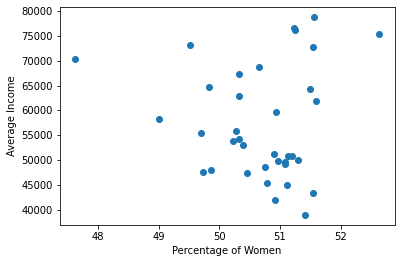

In [9]:
# Create scatter plot: Females & Income
plt.scatter(us_census_by_gender.PercentageOfSexes[us_census_by_gender.Sex == 'Females'], us_census_by_gender.Income[us_census_by_gender.Sex == 'Females']) 
# Add titles to plot
plt.ylabel('Average Income')
plt.xlabel('Percentage of Women')

plt.show()


Result: The distribution of dots across the plot is uniform, with no obvious correlation between states' average income and the proportion of women in each of them, so if the issue with payment inequality still exists by the time of data collection - the scatterplot is probably not an effective method of analysis for this matter, in any case, further investigation is required. 

## Race Data Visualisation via Histogram

Now let's make some histograms out of the race data that we have. As result, we should get the ratio of the number of states to the percentage of residents in them.

First we are going to remove unnecessary "%" symbols, convert values to numerical values and replace `nan` with 0 (because unlike with genders we can't obtain missing value by subtracting every other available race value from the total - resulting value could contain other less widespread national minorities). 

In [10]:
# Remove excessive symbols and convert to numeric
nationalities = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
for column in nationalities:
  us_census[column] = cut_the_tails(us_census[column])
# Fill nan's with 0
us_census.Pacific = us_census.Pacific.fillna(0)

Once again, let's reshape our data, but now in accordance with the race.

In [11]:
us_census_by_race = pd.melt(
    frame=us_census,
    id_vars=["State"], 
    value_vars=nationalities, 
    value_name="PopulationByRace", 
    var_name="RaceType"
)
us_census_by_race

,State,RaceType,PopulationByRace
0,New Jersey,Hispanic,18.749500
1,New Mexico,Hispanic,45.282932
2,New York,Hispanic,17.241425
3,North Carolina,Hispanic,8.464763
4,North Dakota,Hispanic,2.832683
...,...,...,...
211,Missouri,Pacific,0.101657
212,Montana,Pacific,0.072222
213,Nebraska,Pacific,0.057143
214,Nevada,Pacific,0.574521


Now let's plot histograms of different nationalities on a grid for better comparison.

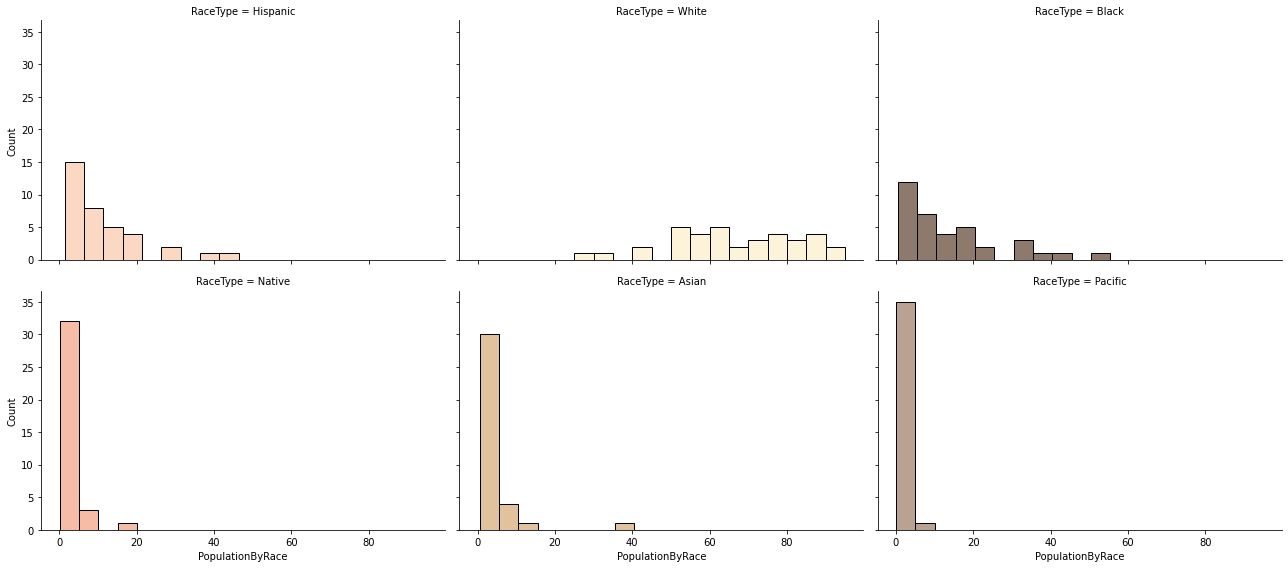

In [12]:
# Create grid
g = sns.FacetGrid(data=us_census_by_race, col='RaceType', col_wrap=3, height=4, aspect=1.5, hue='RaceType', palette=['#f9ccac', '#fbefcc', '#674d3c', '#f4a688', '#d9ad7c', '#a2836e'])
# Add plots to grid
g.map_dataframe(sns.histplot, x='PopulationByRace', binwidth=5)


## Conclusion

We can clearly see that the majority of the population in all states is white which can mean a broad spectrum of people with European and British ancestry.

The number of people with Hispanic and African ancestry in many states is also very high. 

The people with Asian ancestry and Native Americans are significantly less represented across different states compared to European, British, African and Hispanic representatives. 

The least percentage in this dataset consists of people who have Pacific ancestry. 